<a href="https://colab.research.google.com/github/Yongshilin/Forage-BCG-DA/blob/main/Task_3_feature_engineering(revised).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Code by Yongshi Lin

# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [41]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from dateutil.relativedelta import relativedelta  #for a more intuitive handling of year differences.
from collections import Counter  #count frequency

---
## 2. Load data

In [42]:
df = pd.read_csv('clean_data_after_eda.csv')

# change date format
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [43]:
df.head(3)

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23               0.00  ...   
1      2009-08-21   2015-08-31             189.95  ...   
2      2010-04-16   2015-04-17              47.96  ...   

   var_6m_price_off_peak_var  var_6m_price_peak_var  \
0                   0.000131           4.100838e-05   
1                   0.000003           1.217891e-03   
2                   0.000004           9.450150e-08   

   var_6m_price_mid_peak_var  var_6m_price_off_peak_fix  \
0                   0.000908                   2.086294   
1                   0.000000                   0.009482   
2                   0.000000                   0.000000   

   var_6m_price_peak_fix  var_6m_price_mid_peak_fix var_6m_price_off_peak  \
0              99.530517                  44.235794              2.086425   
1               0.000000                   0.000000              0.009485   
2               0.000000                   0.000000              0.000004   

   var_6m_price_peak  var_6m_price_mid_peak  churn  
0       9.953056e+01              44.236702      1  
1       1.217891e-03               0.000000      0  
2       9.450150e-08               0.000000      0  

[3 rows x 44 columns]

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

---

## 3. Feature engineering

Our goal for the feature engineering is to predict churn.

Fearture engineering includes 5 processes:
1. Feature Creation
2. Feature Transformation
3. Feature Extraction
4. Feature Selection
5. Feature Scaling

Steps:
1. Data cleaning
2. Data Transformation
3. Feature Extration
4. Feature Selection
5. Feature Iteration

----
### 1. Feature Creation
#### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [45]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head(3)

id price_date  price_off_peak_var  \
0  038af19179925da21a25619c5a24b745 2015-01-01            0.151367   
1  038af19179925da21a25619c5a24b745 2015-02-01            0.151367   
2  038af19179925da21a25619c5a24b745 2015-03-01            0.151367   

   price_peak_var  price_mid_peak_var  price_off_peak_fix  price_peak_fix  \
0             0.0                 0.0           44.266931             0.0   
1             0.0                 0.0           44.266931             0.0   
2             0.0                 0.0           44.266931             0.0   

   price_mid_peak_fix  
0                 0.0  
1                 0.0  
2                 0.0

In [46]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head(3)

id  offpeak_diff_dec_january_energy  \
0  0002203ffbb812588b632b9e628cc38d                        -0.006192   
1  0004351ebdd665e6ee664792efc4fd13                        -0.004104   
2  0010bcc39e42b3c2131ed2ce55246e3c                         0.050443   

   offpeak_diff_dec_january_power  
0                        0.162916  
1                        0.177779  
2                        1.500000

In [47]:
df = pd.merge(df, diff, on='id')
df.head(3)

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23               0.00  ...   
1      2009-08-21   2015-08-31             189.95  ...   
2      2010-04-16   2015-04-17              47.96  ...   

   var_6m_price_mid_peak_var  var_6m_price_off_peak_fix  \
0                   0.000908                   2.086294   
1                   0.000000                   0.009482   
2                   0.000000                   0.000000   

   var_6m_price_peak_fix  var_6m_price_mid_peak_fix  var_6m_price_off_peak  \
0              99.530517                  44.235794               2.086425   
1               0.000000                   0.000000               0.009485   
2               0.000000                   0.000000               0.000004   

   var_6m_price_peak var_6m_price_mid_peak  churn  \
0       9.953056e+01             44.236702      1   
1       1.217891e-03              0.000000      0   
2       9.450150e-08              0.000000      0   

   offpeak_diff_dec_january_energy  offpeak_diff_dec_january_power  
0                         0.020057                        3.700961  
1                        -0.003767                        0.177779  
2                        -0.004670                        0.177779  

[3 rows x 46 columns]

#### Average price changes across periods
We can now enhance the feature that our colleague made by calculating the average price changes across individual periods, instead of the entire year.

In [48]:
# Aggregate average prices per period by company
mean_price = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 'price_peak_var': 'mean', 'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean', 'price_peak_fix': 'mean', 'price_mid_peak_fix': 'mean'
}).reset_index()

In [49]:
# Calculate the mean difference between consecutive periods
# offpeak: 1st period, peak: 2nd period, midpeak: 3rd period
mean_price['offpeak_peak_var_mean_diff'] = mean_price['price_off_peak_var'] - mean_price['price_peak_var']
mean_price['peak_midpeak_var_mean_diff'] = mean_price['price_peak_var'] - mean_price['price_mid_peak_var']
mean_price['offpeak_midpeak_var_mean_diff'] = mean_price['price_off_peak_var'] - mean_price['price_mid_peak_var']
mean_price['offpeak_peak_fix_mean_diff'] = mean_price['price_off_peak_fix'] - mean_price['price_peak_fix']
mean_price['peak_midpeak_fix_mean_diff'] = mean_price['price_peak_fix'] - mean_price['price_mid_peak_fix']
mean_price['offpeak_midpeak_fix_mean_diff'] = mean_price['price_off_peak_fix'] - mean_price['price_mid_peak_fix']

In [50]:
df = pd.merge(df,
              mean_price[['id','offpeak_peak_var_mean_diff', 'peak_midpeak_var_mean_diff', 'offpeak_midpeak_var_mean_diff',
                          'offpeak_peak_fix_mean_diff', 'peak_midpeak_fix_mean_diff','offpeak_midpeak_fix_mean_diff']],
              on='id')
df.head(3)

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   

  date_modif_prod date_renewal  forecast_cons_12m  ...  var_6m_price_mid_peak  \
0      2015-11-01   2015-06-23               0.00  ...              44.236702   
1      2009-08-21   2015-08-31             189.95  ...               0.000000   
2      2010-04-16   2015-04-17              47.96  ...               0.000000   

   churn  offpeak_diff_dec_january_energy  offpeak_diff_dec_january_power  \
0      1                         0.020057                        3.700961   
1      0                        -0.003767                        0.177779   
2      0                        -0.004670                        0.177779   

   offpeak_peak_var_mean_diff  peak_midpeak_var_mean_diff  \
0                    0.024038                    0.034219   
1                    0.142485                    0.007124   
2                    0.082090                    0.088421   

  offpeak_midpeak_var_mean_diff  offpeak_peak_fix_mean_diff  \
0                      0.058257                   18.590255   
1                      0.149609                   44.311375   
2                      0.170512                   44.385450   

   peak_midpeak_fix_mean_diff  offpeak_midpeak_fix_mean_diff  
0                     7.45067                      26.040925  
1                     0.00000                      44.311375  
2                     0.00000                      44.385450  

[3 rows x 52 columns]

##### Instead of looking at differences across an entire year, we have now created features that look at mean average price differences across different time periods (off_peak, peak, mid_peak). The dec-jan feature may reveal macro patterns that occur over an entire year, whereas inter-time-period features may reveal patterns on a micro scale between months.

#### Max price changes across periods and months
Another way we can enhance the feature from our colleague is to look at the maximum change in prices across periods and months.

In [51]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 'price_peak_var': 'mean', 'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean', 'price_peak_fix': 'mean', 'price_mid_peak_fix': 'mean'
}).reset_index()

In [52]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['offpeak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_midpeak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['offpeak_midpeak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['offpeak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_midpeak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['offpeak_midpeak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [53]:
# Calculate the maximum monthly difference across time periods
maxdiff_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'offpeak_peak_var_mean_diff': 'max', 'peak_midpeak_var_mean_diff':'max', 'offpeak_midpeak_var_mean_diff':'max',
    'offpeak_peak_fix_mean_diff':'max', 'peak_midpeak_fix_mean_diff':'max', 'offpeak_midpeak_fix_mean_diff':'max'
}).reset_index().rename(
    columns = {
        'offpeak_peak_var_mean_diff': 'offpeak_peak_var_max_monthly_diff',
        'peak_midpeak_var_mean_diff': 'peak_midpeak_var_max_monthly_diff',
        'offpeak_midpeak_var_mean_diff':'offpeak_midpeak_var_max_monthly_diff',
        'offpeak_peak_fix_mean_diff':'offpeak_peak_fix_max_monthly_diff',
        'peak_midpeak_fix_mean_diff':'peak_midpeak_fix_max_monthly_diff',
        'offpeak_midpeak_fix_mean_diff':'offpeak_midpeak_fix_max_monthly_diff'
    }
)

In [54]:
df = pd.merge(df,
              maxdiff_periods_months[['id','offpeak_peak_var_max_monthly_diff', 'peak_midpeak_var_max_monthly_diff', 'offpeak_midpeak_var_max_monthly_diff',
                          'offpeak_peak_fix_max_monthly_diff', 'peak_midpeak_fix_max_monthly_diff','offpeak_midpeak_fix_max_monthly_diff']],
              on='id')
df.head(3)

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   

  date_modif_prod date_renewal  forecast_cons_12m  ...  \
0      2015-11-01   2015-06-23               0.00  ...   
1      2009-08-21   2015-08-31             189.95  ...   
2      2010-04-16   2015-04-17              47.96  ...   

   offpeak_midpeak_var_mean_diff  offpeak_peak_fix_mean_diff  \
0                       0.058257                   18.590255   
1                       0.149609                   44.311375   
2                       0.170512                   44.385450   

   peak_midpeak_fix_mean_diff  offpeak_midpeak_fix_mean_diff  \
0                     7.45067                      26.040925   
1                     0.00000                      44.311375   
2                     0.00000                      44.385450   

   offpeak_peak_var_max_monthly_diff  peak_midpeak_var_max_monthly_diff  \
0                           0.060550                           0.085483   
1                           0.151367                           0.085483   
2                           0.084587                           0.089162   

  offpeak_midpeak_var_max_monthly_diff  offpeak_peak_fix_max_monthly_diff  \
0                             0.146033                           44.26693   
1                             0.151367                           44.44471   
2                             0.172468                           44.44471   

   peak_midpeak_fix_max_monthly_diff  offpeak_midpeak_fix_max_monthly_diff  
0                           8.145775                              44.26693  
1                           0.000000                              44.44471  
2                           0.000000                              44.44471  

[3 rows x 58 columns]

##### As a Utilities customer, there is nothing more annoying than sudden price changes between months, and a large increase in prices within a short time span would be an influencing factor in causing customer to look at other utilities providers for a better deal.

----
### 2. Feature Scaling & Transformation

#### Tenure

In [55]:
# Calculating tenure in years using relativedelta
df['tenure'] = df.apply(lambda row: relativedelta(row['date_end'], row['date_activ']).years, axis=1)
# relativedelta(row['date_end'], row['date_activ']).years: calculates the number of full years between the date_end and date_activ dates

In [56]:
df.groupby(['tenure']).agg({'churn':'mean'}).sort_values(by = 'churn', ascending = False)

churn
tenure          
2       0.171875
3       0.140351
4       0.127636
13      0.095238
5       0.088992
12      0.083333
6       0.078161
7       0.073485
11      0.060109
8       0.048780
10      0.044444
9       0.012500

##### We can see that companies who have only been a client for 4 or less months are much more likely to churn compared to companies that have been a client for longer. Interestingly, the difference between 4 and 5 months is about 4%, which represents a large jump in likelihood for a customer to churn compared to the other differences between ordered tenure values. Perhaps this reveals that getting a customer to over 4 months tenure is actually a large milestone with respect to keeping them as a long term customer.

This is an interesting feature to keep for modelling because clearly how long you've been a client, has a influence on the chance of a client churning.

#### Transform dates into months
- months_activ = Number of months active until reference date (Jan 2016)
- months_to_end = Number of months of the contract left until reference date (Jan 2016)
- months_modif_prod = Number of months since last modification until reference date (Jan 2016)
- months_renewal = Number of months since last renewal until reference date (Jan 2016)

In [57]:
# Function to calculate the difference in months
def calculate_months(start_date, end_date):
    delta = relativedelta(end_date, start_date)
    return delta.years * 12 + delta.months

In [58]:
# Create reference date
reference_date = datetime(2016, 1, 1) #or reference_date = pd.Timestamp('2016-01-01')

# Applying the function to create new columns
df['months_activ'] = df.apply(lambda row: calculate_months(row['date_activ'], reference_date), axis=1)   #or use pd.to_datetime('today') for the end_date for today
df['months_to_end'] = df.apply(lambda row: -calculate_months(row['date_end'], reference_date), axis=1)
df['months_modif_prod'] = df.apply(lambda row: calculate_months(row['date_modif_prod'], reference_date), axis=1)
df['months_renewal'] = df.apply(lambda row: calculate_months(row['date_renewal'], reference_date), axis=1)

In [59]:
# drop dates columns
df = df.drop(columns = ['date_activ', 'date_end', 'date_modif_prod', 'date_renewal'])
df.head()

id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
0         0         54946                0               0.00   
1      4660             0                0             189.95   
2       544             0                0              47.96   
3      1584             0                0             240.04   
4      4425             0              526             445.75   

   forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
0                   0                       0.0                     1.78   
1                   0                       0.0                    16.27   
2                   0                       0.0                    38.72   
3                   0                       0.0                    19.83   
4                 526                       0.0                   131.73   

   forecast_price_energy_off_peak  ...  peak_midpeak_var_max_monthly_diff  \
0                        0.114481  ...                           0.085483   
1                        0.145711  ...                           0.085483   
2                        0.165794  ...                           0.089162   
3                        0.146694  ...                           0.000000   
4                        0.116900  ...                           0.033743   

   offpeak_midpeak_var_max_monthly_diff offpeak_peak_fix_max_monthly_diff  \
0                              0.146033                         44.266930   
1                              0.151367                         44.444710   
2                              0.172468                         44.444710   
3                              0.153133                         44.444710   
4                              0.055866                         16.291555   

   peak_midpeak_fix_max_monthly_diff  offpeak_midpeak_fix_max_monthly_diff  \
0                           8.145775                              44.26693   
1                           0.000000                              44.44471   
2                           0.000000                              44.44471   
3                           0.000000                              44.44471   
4                           8.145775                              24.43733   

   tenure  months_activ  months_to_end  months_modif_prod months_renewal  
0       3            30              5                  2              6  
1       7            76              7                 76              4  
2       6            68              3                 68              8  
3       6            69              2                 69              9  
4       6            71              2                 71              9  

[5 rows x 59 columns]

##### Dates as a datetime object are not useful for a predictive model, so we needed to use the datetimes to create some other features that may hold some predictive power.

Using intuition, you could assume that a client who has been an active client of PowerCo for a longer amount of time may have more loyalty to the brand and is more likely to stay. Whereas a newer client may be more volatile. Hence the addition of the months_activ feature.

As well as this, if we think from the perspective of a client with PowerCo, if you're coming toward the end of your contract with PowerCo your thoughts could go a few ways. You could be looking for better deals for when your contract ends, or you might want to see out your contract and sign another one. One the other hand if you've only just joined, you may have a period where you're allowed to leave if you're not satisfied. Furthermore, if you're in the middle of your contract, their may be charges if you wanted to leave, deterring clients from churning mid-way through their agreement. So, I think months_to_end will be an interesting feature because it may reveal patterns and behaviours about timing of churn.

My belief is that if a client has made recent updates to their contract, they are more likely to be satisfied or at least they have received a level of customer service to update or change their existing services. I believe this to be a positive sign, they are an engaged customer, and so I believe months_modif_prod will be an interesting feature to include because it shows the degree of how 'engaged' a client is with PowerCo.

Finally the number of months since a client last renewed a contract I believe will be an interesting feature because once again, it shows the degree to which that client is engaged. It also goes a step further than just engagement, it shows a level of commitment if a client renews their contract. For this reason, I believe months_renewal will be a good feature to include.

#### Transforming Boolean data
'has_gas': transform this column from being categorical to being a binary flag

In [60]:
print(df['has_gas'].unique())

['t' 'f']


In [61]:
# Convert 'region' to binary values
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0]) #1 means has gas, 0 means not. #or  df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn':'mean'})

churn
has_gas          
0        0.100544
1        0.081856

##### If a customer also buys gas from PowerCo, it shows that they have multiple products and are a loyal customer to the brand. Hence, it is no surprise that customers who do not buy gas are almost 2% more likely to churn than customers who also buy gas from PowerCo. Hence, this is a useful feature.

#### Transforming categorical data
A predictive model cannot accept categorical or string values, hence we need to encode categorical features into numerical representations in the most compact and discriminative way possible.

Use dummy variables AKA one hot encoding to encode categorical features. This create a new feature for every unique value of a categorical column, and fills this column with either a 1 or a 0 to indicate that this company does or does not belong to this category.

'channel_sales'

In [62]:
# transforming into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')
df['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: count, dtype: int64

##### We have 8 categories, so we will create 8 dummy variables from this column. However, as you can see the last 3 categories in the output above, show that they only have 11, 3 and 2 occurrences respectively. Considering that our dataset has about 14000 rows, this means that these dummy variables will be almost entirely 0 and so will not add much predictive power to the model at all (since they're almost entirely a constant value and provide very little).

For this reason, we will drop these 3 dummy variables.

In [63]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head(3)

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57         0         54946                0   
1  d29c2c54acc38ff3c0614d0a653813dd      4660             0                0   
2  764c75f661154dac3a6c254cd082ea7d       544             0                0   

   forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
0               0.00                   0                       0.0   
1             189.95                   0                       0.0   
2              47.96                   0                       0.0   

   forecast_meter_rent_12m  forecast_price_energy_off_peak  \
0                     1.78                        0.114481   
1                    16.27                        0.145711   
2                    38.72                        0.165794   

   forecast_price_energy_peak  ...  tenure  months_activ  months_to_end  \
0                    0.098142  ...       3            30              5   
1                    0.000000  ...       7            76              7   
2                    0.087899  ...       6            68              3   

   months_modif_prod  months_renewal  channel_MISSING  \
0                  2               6            False   
1                 76               4             True   
2                 68               8            False   

   channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                                     False   
1                                     False   
2                                     False   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                      True   
1                                     False   
2                                      True   

  channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                    False   
1                                    False   
2                                    False   

   channel_usilxuppasemubllopkaafesmlibmsdf  
0                                     False  
1                                     False  
2                                     False  

[3 rows x 63 columns]

##### 'origin_up'

In [64]:
df['origin_up'] = df['origin_up'].astype('category')
df['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

##### Similar to channel_sales the last 3 categories in the output above show very low frequency, so we will remove these from the features after creating dummy variables.

In [65]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head(3)

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57         0         54946                0   
1  d29c2c54acc38ff3c0614d0a653813dd      4660             0                0   
2  764c75f661154dac3a6c254cd082ea7d       544             0                0   

   forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
0               0.00                   0                       0.0   
1             189.95                   0                       0.0   
2              47.96                   0                       0.0   

   forecast_meter_rent_12m  forecast_price_energy_off_peak  \
0                     1.78                        0.114481   
1                    16.27                        0.145711   
2                    38.72                        0.165794   

   forecast_price_energy_peak  ...  months_modif_prod  months_renewal  \
0                    0.098142  ...                  2               6   
1                    0.000000  ...                 76               4   
2                    0.087899  ...                 68               8   

   channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0            False                                     False   
1             True                                     False   
2            False                                     False   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                      True   
1                                     False   
2                                      True   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                     False   
1                                     False   
2                                     False   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                     False   
1                                     False   
2                                     False   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                       False   
1                                        True   
2                                        True   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                       False   
1                                       False   
2                                       False   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                        True  
1                                       False  
2                                       False  

[3 rows x 65 columns]

In [66]:
# Convert all boolean columns to binary integers
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)
df.head(3)

id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57         0         54946                0   
1  d29c2c54acc38ff3c0614d0a653813dd      4660             0                0   
2  764c75f661154dac3a6c254cd082ea7d       544             0                0   

   forecast_cons_12m  forecast_cons_year  forecast_discount_energy  \
0               0.00                   0                       0.0   
1             189.95                   0                       0.0   
2              47.96                   0                       0.0   

   forecast_meter_rent_12m  forecast_price_energy_off_peak  \
0                     1.78                        0.114481   
1                    16.27                        0.145711   
2                    38.72                        0.165794   

   forecast_price_energy_peak  ...  months_modif_prod  months_renewal  \
0                    0.098142  ...                  2               6   
1                    0.000000  ...                 76               4   
2                    0.087899  ...                 68               8   

   channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                0                                         0   
1                1                                         0   
2                0                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         0   
2                                         1   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                         0   
1                                         0   
2                                         0   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                           0   
1                                           1   
2                                           1   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                           0   
1                                           0   
2                                           0   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                           1  
1                                           0  
2                                           0  

[3 rows x 65 columns]

#### Transforming numerical data
In the previous exercise we saw that some variables were highly skewed. The reason why we need to treat skewness is because some predictive models have inherent assumptions about the distribution of the features that are being supplied to it. Such models are called parametric models, and they typically assume that all variables are both independent and normally distributed.

Skewness isn't always a bad thing, but as a rule of thumb it is always good practice to treat highly skewed variables because of the reason stated above, but also as it can improve the speed at which predictive models are able to converge to its best solution.

There are many ways that you can treat skewed variables. You can apply transformations such as:

Square root
Cubic root
Logarithm
to a continuous numeric column and you will notice the distribution changes. For this use case we will use the 'Logarithm' transformation for the positively skewed features.

Note: We cannot apply log to a value of 0, so we will add a constant to all the values.

#### Sknewness

In [67]:
skewed = [
    'cons_12m',
    'cons_gas_12m',
    'cons_last_month',
    'forecast_cons_12m',
    'forecast_cons_year',
    'forecast_discount_energy',
    'forecast_meter_rent_12m',
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak',
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  1.460600e+04  1.460600e+04     14606.000000       14606.000000   
mean   1.592203e+05  2.809238e+04     16090.269752        1868.614880   
std    5.734653e+05  1.629731e+05     64364.196422        2387.571531   
min    0.000000e+00  0.000000e+00         0.000000           0.000000   
25%    5.674750e+03  0.000000e+00         0.000000         494.995000   
50%    1.411550e+04  0.000000e+00       792.500000        1112.875000   
75%    4.076375e+04  0.000000e+00      3383.000000        2401.790000   
max    6.207104e+06  4.154590e+06    771203.000000       82902.830000   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean          1399.762906                  0.966726                63.086871   
std           3247.786255                  5.108289                66.165783   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                16.180000   
50%            314.000000                  0.000000                18.795000   
75%           1745.750000                  0.000000               131.030000   
max         175375.000000                 30.000000               599.310000   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14606.000000                14606.000000   
mean                         0.137283                    0.050491   
std                          0.024623                    0.049037   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak  
count                 14606.000000  
mean                     43.130056  
std                       4.485988  
min                       0.000000  
25%                      40.606701  
50%                      44.311378  
75%                      44.311378  
max                      59.266378

##### We can see that the standard deviation for most of these features is quite high.

In [68]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [69]:
df[skewed].describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  14606.000000  14606.000000     14606.000000       14606.000000   
mean       4.223939      0.779244         2.264646           2.962177   
std        0.884515      1.717071         1.769305           0.683592   
min        0.000000      0.000000         0.000000           0.000000   
25%        3.754023      0.000000         0.000000           2.695477   
50%        4.149727      0.000000         2.899547           3.046836   
75%        4.610285      0.000000         3.529430           3.380716   
max        6.792889      6.618528         5.887169           4.918575   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean             1.784610                  0.966726                 1.517203   
std              1.584986                  5.108289                 0.571481   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                 1.235023   
50%              2.498311                  0.000000                 1.296555   
75%              3.242231                  0.000000                 2.120673   
max              5.243970                 30.000000                 2.778376   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14606.000000                14606.000000   
mean                         0.137283                    0.050491   
std                          0.024623                    0.049037   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak  
count                 14606.000000  
mean                     43.130056  
std                       4.485988  
min                       0.000000  
25%                      40.606701  
50%                      44.311378  
75%                      44.311378  
max                      59.266378

##### Now we can see that for the majority of the features, their standard deviation is much lower after transformation. This is a good thing, it shows that these features are more stable and predictable now.

Let's quickly check the distributions of some of these features too.

#### Consumption

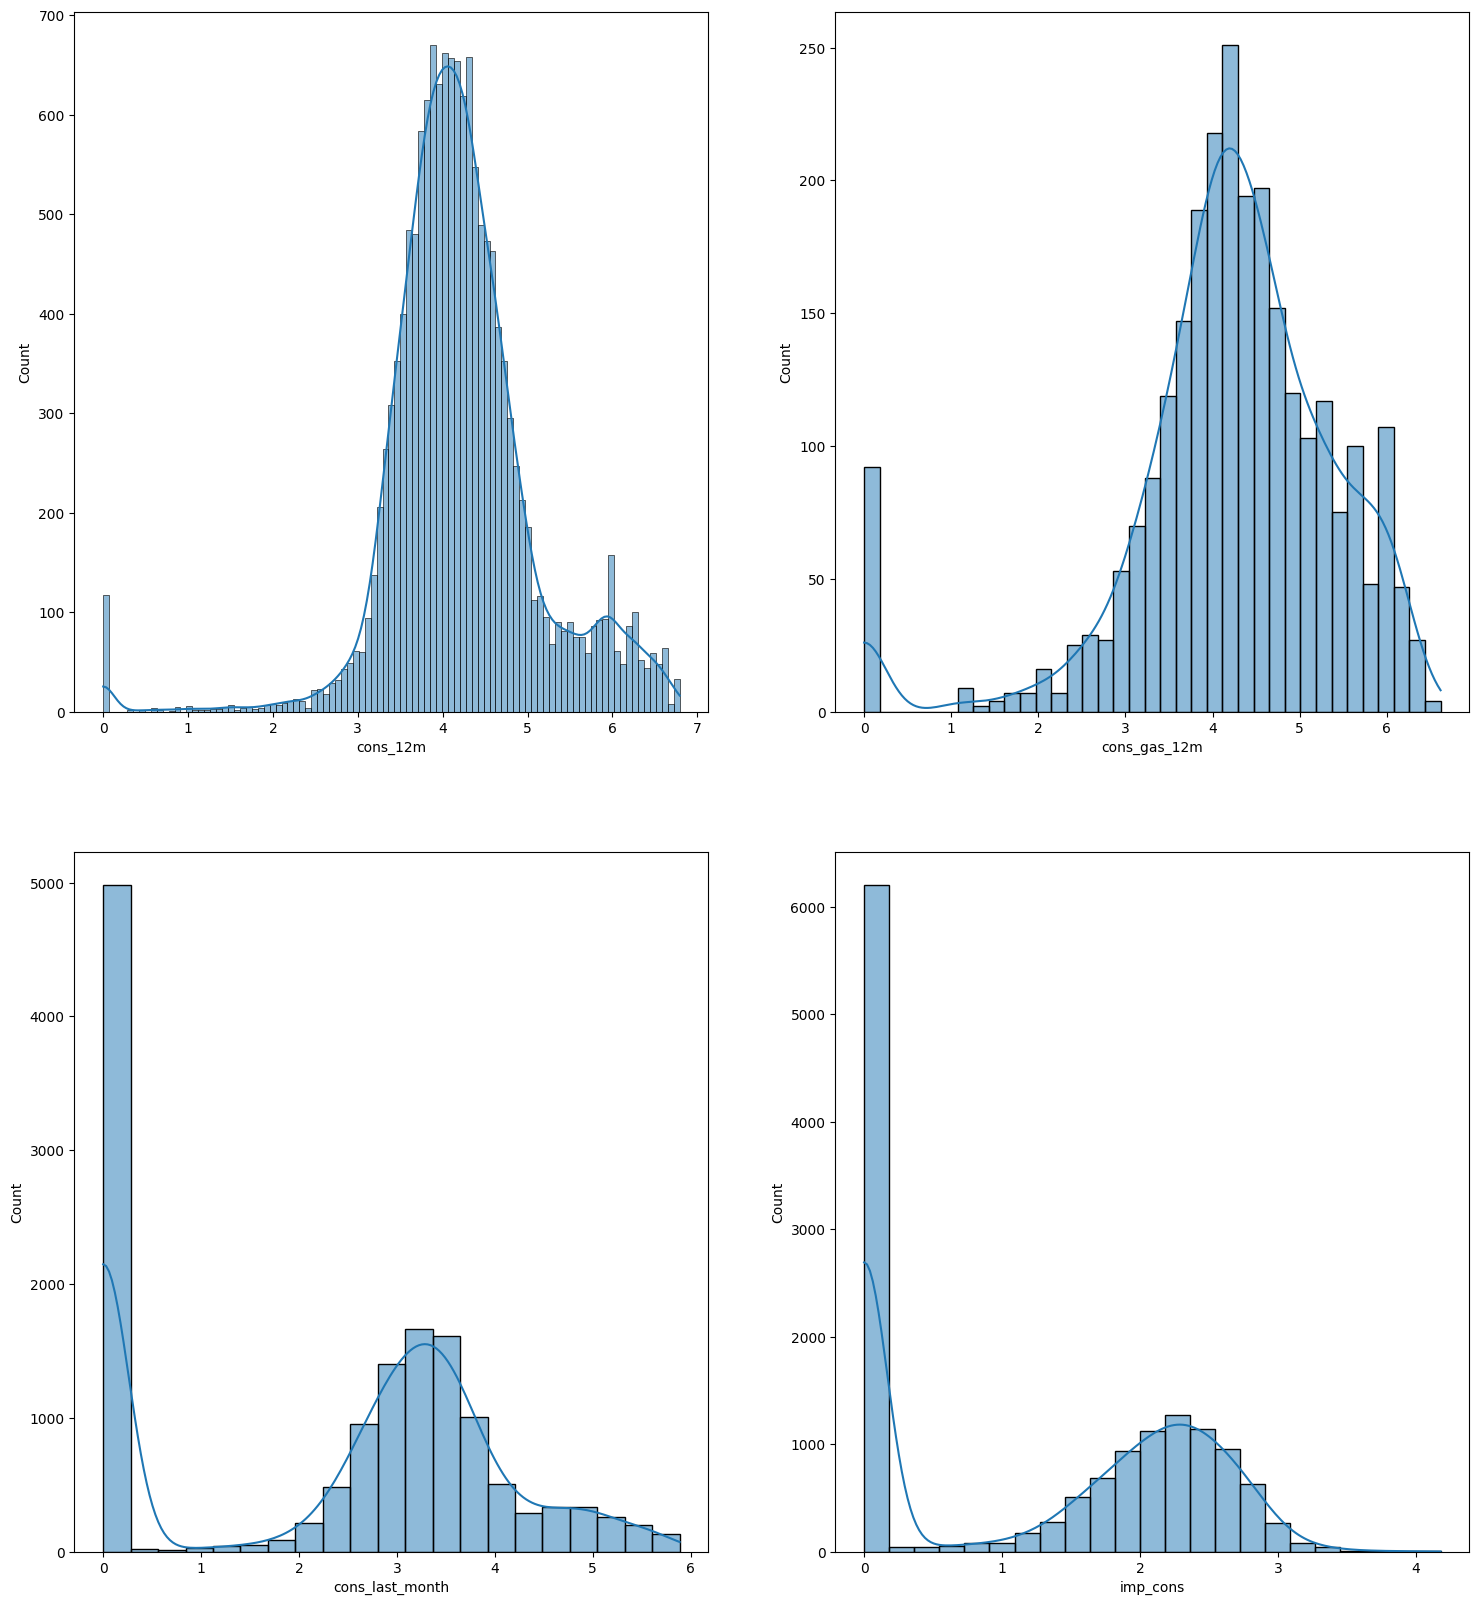

In [81]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(18, 20))
# Plot histograms
sns.histplot((df["cons_12m"].dropna()), ax=axs[0,0], kde=True)
sns.histplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[0,1], kde=True)
sns.histplot((df["cons_last_month"].dropna()), ax=axs[1,0],kde=True)
sns.histplot((df["imp_cons"].dropna()), ax=axs[1,1],kde=True)

plt.show()

#### Forecast

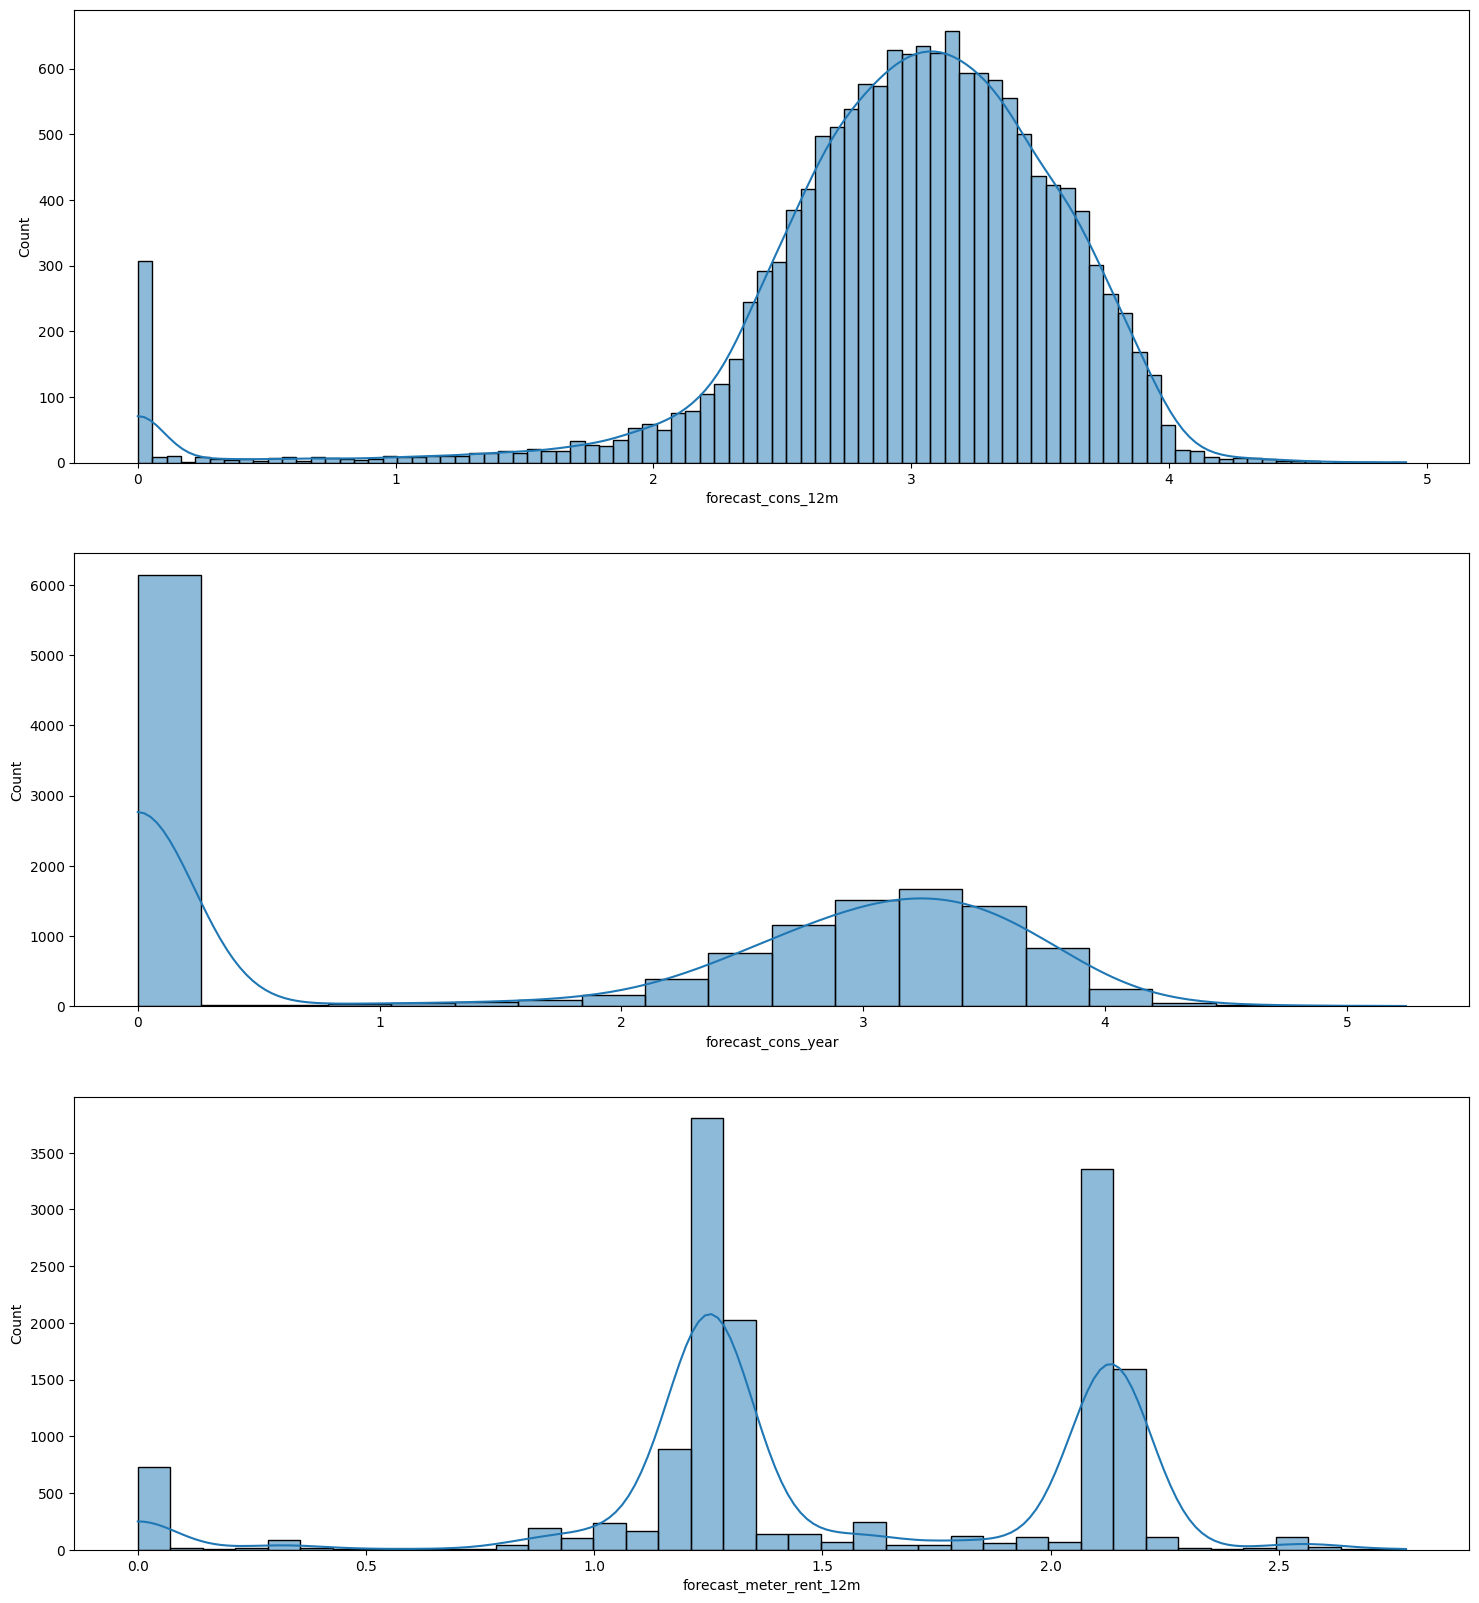

In [75]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.histplot((df["forecast_cons_12m"].dropna()), ax=axs[0], kde=True)
sns.histplot((df["forecast_cons_year"].dropna()), ax=axs[1], kde=True)
sns.histplot((df["forecast_meter_rent_12m"].dropna()), ax=axs[2],kde=True)
plt.show()

#### Rescale forecast energy and power price for comparison

In [79]:
# Initialize Min-Max Scaler
scaler = MinMaxScaler()

forecast_price = df[['forecast_price_energy_off_peak','forecast_price_energy_peak', 'forecast_price_pow_off_peak']]

# Fit and transform the data
scaled_forecast_price = scaler.fit_transform(forecast_price)

# Convert back to DataFrame
scaled_fp_df = pd.DataFrame(scaled_forecast_price, columns=forecast_price.columns)
scaled_fp_df.head()

forecast_price_energy_off_peak  forecast_price_energy_peak  \
0                        0.417870                    0.500788   
1                        0.531864                    0.000000   
2                        0.605169                    0.448521   
3                        0.535452                    0.000000   
4                        0.426700                    0.510346   

   forecast_price_pow_off_peak  
0                     0.685156  
1                     0.747665  
2                     0.747665  
3                     0.747665  
4                     0.685156

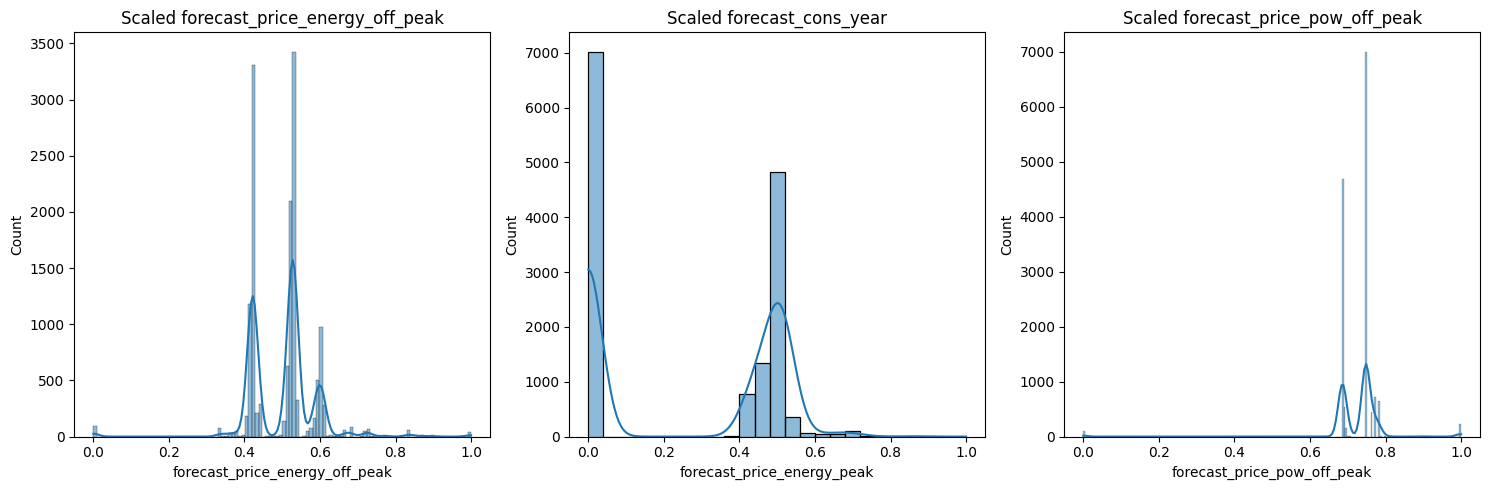

In [80]:
# visualizing scaled data
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

sns.histplot(scaled_fp_df['forecast_price_energy_off_peak'], ax=axs[0], kde=True)
sns.histplot(scaled_fp_df['forecast_price_energy_peak'], ax=axs[1], kde=True)
sns.histplot(scaled_fp_df['forecast_price_pow_off_peak'], ax=axs[2], kde=True)

axs[0].set_title('Scaled forecast_price_energy_off_peak')
axs[1].set_title('Scaled forecast_cons_year')
axs[2].set_title('Scaled forecast_price_pow_off_peak')

plt.tight_layout()
plt.show()

#### Subscribed Power & Power Suscription

In [65]:
# remove outlier
def remove_outliers_iqr(data, *columns):
    """
    Remove outliers from specified columns using the IQR method.

    Parameters:
    - data (pd.DataFrame): The input DataFrame.
    - columns (list of str): Columns to remove outliers from.

    Returns:
    - pd.DataFrame: DataFrame with outliers removed.
    """
    data_cleaned = data.copy()

    for column in columns:
        Q1 = data_cleaned[column].quantile(0.25)
        Q3 = data_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        data_cleaned = data_cleaned[(data_cleaned[column] >= lower_bound) & (data_cleaned[column] <= upper_bound)]

    return data_cleaned

In [24]:
power = df[['id', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin', 'pow_max', 'churn']]

In [25]:
# apply remove outlier function
power_cleaned = remove_outliers_iqr(power, 'margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin', 'pow_max')
power_cleaned.head()

id  margin_gross_pow_ele  margin_net_pow_ele  \
1  d29c2c54acc38ff3c0614d0a653813dd                 16.38               16.38   
2  764c75f661154dac3a6c254cd082ea7d                 28.60               28.60   
3  bba03439a292a1e166f80264c16191cb                 30.22               30.22   
4  149d57cf92fc41cf94415803a877cb4b                 44.91               44.91   
5  1aa498825382410b098937d65c4ec26d                 33.12               33.12   

   net_margin  pow_max  churn  
1       18.89   13.800      0  
2        6.60   13.856      0  
3       25.46   13.200      0  
4       47.98   19.800      0  
5      118.89   13.200      1

In [26]:
# Feature Scaling - standardation
scaler = StandardScaler()
power_scaled = pd.DataFrame(scaler.fit_transform(power_cleaned[['margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin', 'pow_max']]),
                                  columns=['margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin', 'pow_max'])
power_scaled = pd.concat([power_scaled, power_cleaned[['id','churn']].reset_index(drop=True)], axis=1)
power_scaled.head()

margin_gross_pow_ele  margin_net_pow_ele  net_margin   pow_max  \
0             -0.472877           -0.472660   -0.961556 -0.036081   
1              0.763618            0.763976   -1.068977 -0.018169   
2              0.927540            0.927916   -0.904131 -0.227999   
3              2.413965            2.414510   -0.707294  1.883099   
4              1.220980            1.221390   -0.087505 -0.227999   

                                 id  churn  
0  d29c2c54acc38ff3c0614d0a653813dd      0  
1  764c75f661154dac3a6c254cd082ea7d      0  
2  bba03439a292a1e166f80264c16191cb      0  
3  149d57cf92fc41cf94415803a877cb4b      0  
4  1aa498825382410b098937d65c4ec26d      1

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


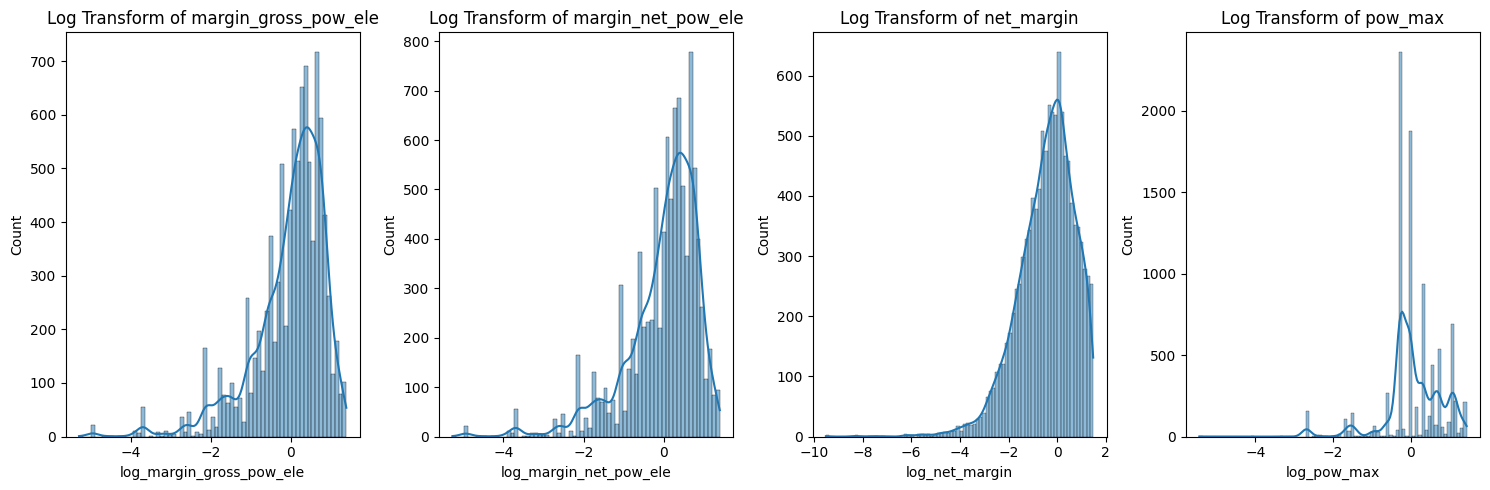

In [144]:
# log transform
# too many 0 value, shift a constant value to all values before applying the log transformation ensures that zeros are handled properly
const = 1e-6
power_scaled.loc[:, 'log_margin_gross_pow_ele'] = np.log1p(power_scaled['margin_gross_pow_ele']+const)
power_scaled.loc[:, 'log_margin_net_pow_ele'] = np.log1p(power_scaled['margin_net_pow_ele']+const)
power_scaled.loc[:, 'log_net_margin'] = np.log1p(power_scaled['net_margin']+const)
power_scaled.loc[:, 'log_pow_max'] = np.log1p(power_scaled['pow_max']+const)

# Visualizing the transformations
fig, axs = plt.subplots(ncols=4, figsize=(15, 5))

sns.histplot(power_scaled['log_margin_gross_pow_ele'], ax=axs[0], kde=True)
sns.histplot(power_scaled['log_margin_net_pow_ele'], ax=axs[1], kde=True)
sns.histplot(power_scaled['log_net_margin'], ax=axs[2], kde=True)
sns.histplot(power_scaled['log_pow_max'], ax=axs[3], kde=True)

axs[0].set_title('Log Transform of margin_gross_pow_ele')
axs[1].set_title('Log Transform of margin_net_pow_ele')
axs[2].set_title('Log Transform of net_margin')
axs[3].set_title('Log Transform of pow_max')

plt.tight_layout()
plt.show()

#### Var Year Energy Price

In [99]:
var_year_price = df[['id', 'var_year_price_off_peak_var', 'var_year_price_peak_var', 'var_year_price_mid_peak_var',
                     'var_year_price_off_peak_fix', 'var_year_price_peak_fix', 'var_year_price_mid_peak_fix',
                     'var_year_price_off_peak', 'var_year_price_peak', 'var_year_price_mid_peak', 'churn']]

In [91]:
# the third function plot_distribution helps you to plot the distribution of a numeric column
def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})
    # Plot the histogram
    temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

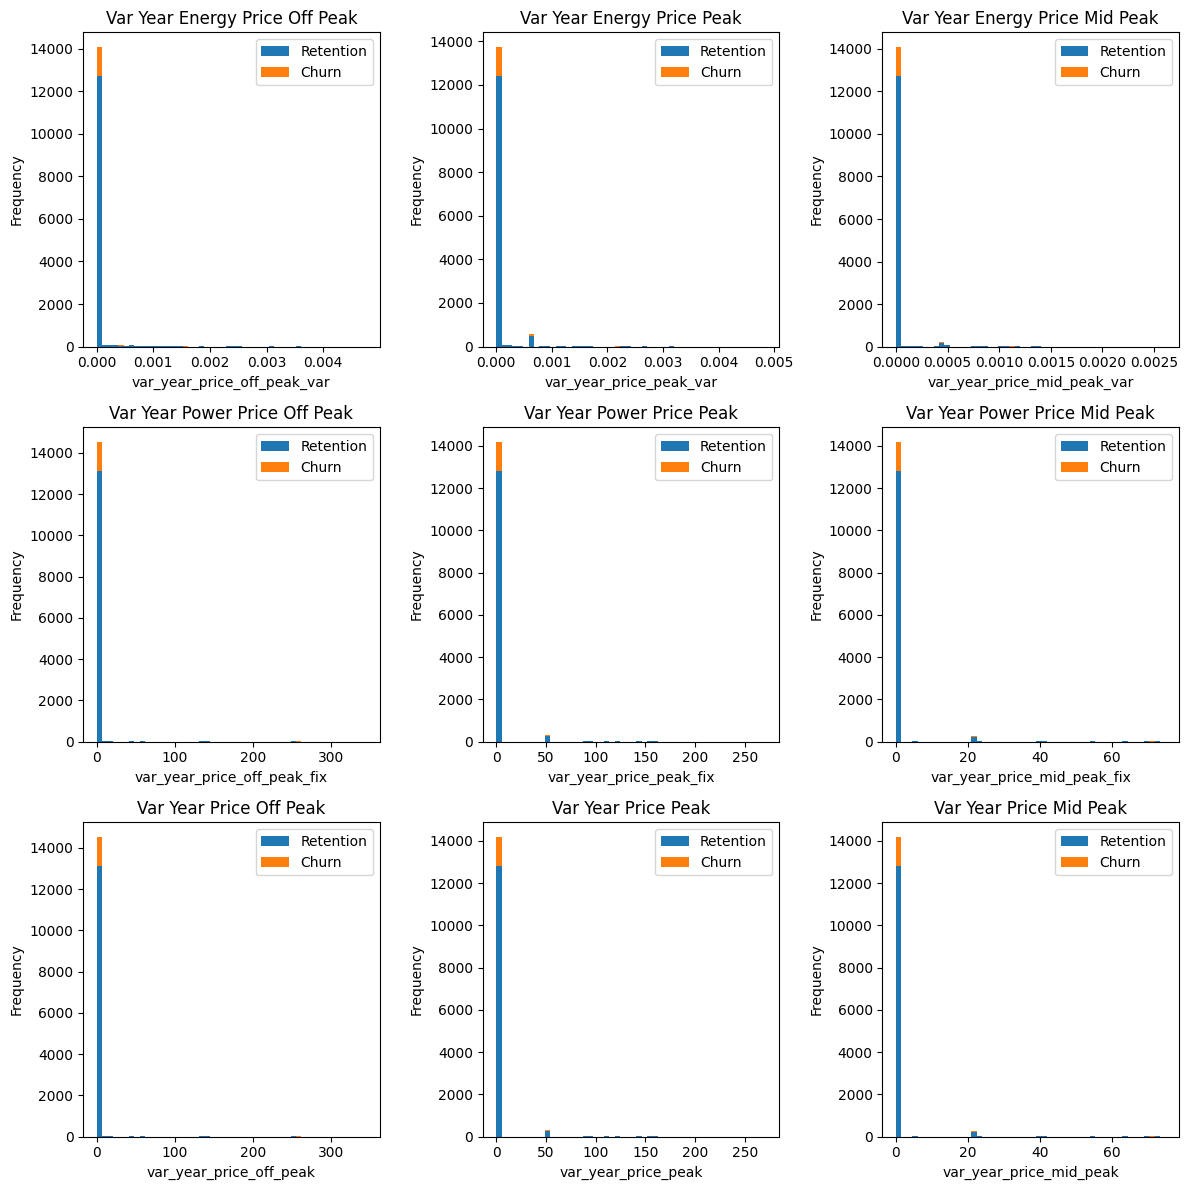

In [106]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

plot_distribution(var_year_price, 'var_year_price_off_peak_var', axs[0,0])
plot_distribution(var_year_price, 'var_year_price_peak_var', axs[0,1])
plot_distribution(var_year_price, 'var_year_price_mid_peak_var', axs[0,2])

plot_distribution(var_year_price, 'var_year_price_off_peak_fix', axs[1,0])
plot_distribution(var_year_price, 'var_year_price_peak_fix', axs[1,1])
plot_distribution(var_year_price, 'var_year_price_mid_peak_fix', axs[1,2])

plot_distribution(var_year_price, 'var_year_price_off_peak', axs[2,0])
plot_distribution(var_year_price, 'var_year_price_peak', axs[2,1])
plot_distribution(var_year_price, 'var_year_price_mid_peak', axs[2,2])

axs[0,0].set_title('Var Year Energy Price Off Peak')
axs[0,1].set_title('Var Year Energy Price Peak')
axs[0,2].set_title('Var Year Energy Price Mid Peak')

axs[1,0].set_title('Var Year Power Price Off Peak')
axs[1,1].set_title('Var Year Power Price Peak')
axs[1,2].set_title('Var Year Power Price Mid Peak')

axs[2,0].set_title('Var Year Price Off Peak')
axs[2,1].set_title('Var Year Price Peak')
axs[2,2].set_title('Var Year Price Mid Peak')

plt.tight_layout()
plt.show()

#### Var 6-Months Price

In [103]:
var_6m_price = df[['id', 'var_6m_price_off_peak_var', 'var_6m_price_peak_var', 'var_6m_price_mid_peak_var',
                    'var_6m_price_off_peak_fix', 'var_6m_price_peak_fix', 'var_6m_price_mid_peak_fix',
                    'var_6m_price_off_peak', 'var_6m_price_peak', 'var_6m_price_mid_peak','churn']]

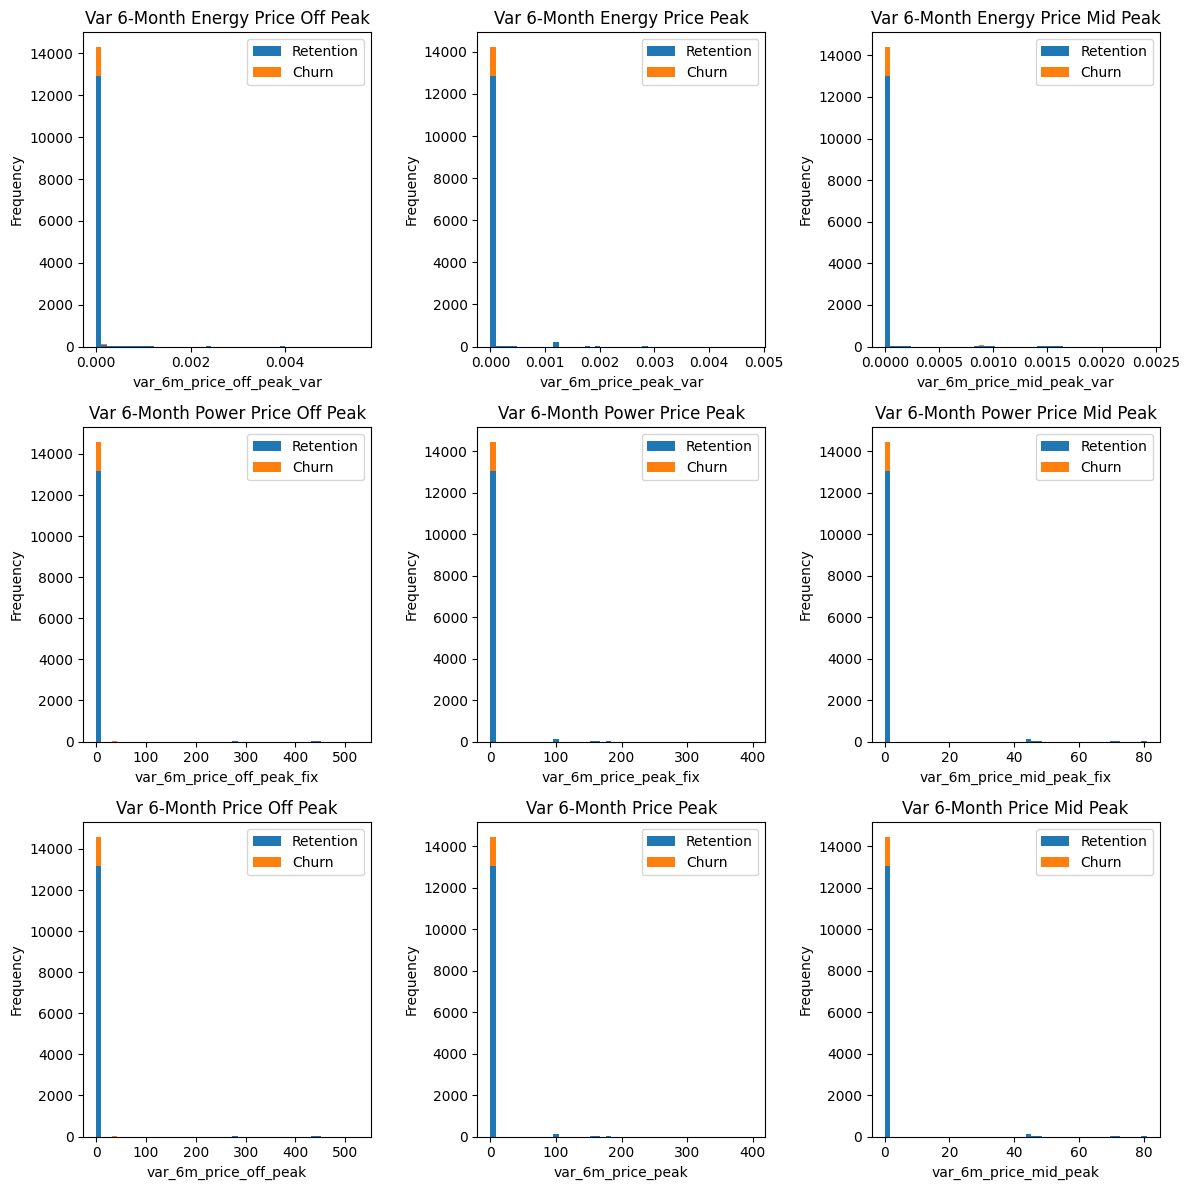

In [107]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

plot_distribution(var_6m_price, 'var_6m_price_off_peak_var', axs[0,0])
plot_distribution(var_6m_price, 'var_6m_price_peak_var', axs[0,1])
plot_distribution(var_6m_price, 'var_6m_price_mid_peak_var', axs[0,2])

plot_distribution(var_6m_price, 'var_6m_price_off_peak_fix', axs[1,0])
plot_distribution(var_6m_price, 'var_6m_price_peak_fix', axs[1,1])
plot_distribution(var_6m_price, 'var_6m_price_mid_peak_fix', axs[1,2])

plot_distribution(var_6m_price, 'var_6m_price_off_peak', axs[2,0])
plot_distribution(var_6m_price, 'var_6m_price_peak', axs[2,1])
plot_distribution(var_6m_price, 'var_6m_price_mid_peak', axs[2,2])

axs[0,0].set_title('Var 6-Month Energy Price Off Peak')
axs[0,1].set_title('Var 6-Month Energy Price Peak')
axs[0,2].set_title('Var 6-Month Energy Price Mid Peak')

axs[1,0].set_title('Var 6-Month Power Price Off Peak')
axs[1,1].set_title('Var 6-Month Power Price Peak')
axs[1,2].set_title('Var 6-Month Power Price Mid Peak')

axs[2,0].set_title('Var 6-Month Price Off Peak')
axs[2,1].set_title('Var 6-Month Price Peak')
axs[2,2].set_title('Var 6-Month Price Mid Peak')

plt.tight_layout()
plt.show()

### Feature Extraction - Dimensionality Reduction

PCA Analysis for Cleaned dataset

In [109]:
# Select only the numerical columns and drop any categorical column
df1_dropped = df.drop(columns=['churn', 'has_gas'])
num_df1 = df1_dropped.select_dtypes(include=['number'])

In [84]:
num_pcs = PCA()
num_pcs.fit(num_df1.dropna(axis=0))
num_pcsSummary_df = pd.DataFrame({'Standard deviation': np.sqrt(num_pcs.explained_variance_),
                           'Proportion of variance': num_pcs.explained_variance_ratio_,
                           'Cumulative proportion': np.cumsum(num_pcs.explained_variance_ratio_)})
num_pcsSummary_df = num_pcsSummary_df.transpose()
num_pcsSummary_df.columns = ['PC{}'.format(i) for i in range(1, len(num_pcsSummary_df.columns) + 1)]
num_pcsSummary_df.round(4)

PC1      PC2      PC3      PC4      PC5      PC6  \
Standard deviation      311.9017  34.4889  32.0908  29.8792  23.3179  21.0739   
Proportion of variance    0.9535   0.0117   0.0101   0.0087   0.0053   0.0044   
Cumulative proportion     0.9535   0.9651   0.9752   0.9840   0.9893   0.9936   

                            PC7      PC8      PC9    PC10  ...  PC53  PC54  \
Standard deviation      16.2134  11.7812  10.7124  5.6250  ...   0.0   0.0   
Proportion of variance   0.0026   0.0014   0.0011  0.0003  ...   0.0   0.0   
Cumulative proportion    0.9962   0.9976   0.9987  0.9990  ...   1.0   1.0   

                        PC55  PC56  PC57  PC58  PC59  PC60  PC61  PC62  
Standard deviation       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Proportion of variance   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
Cumulative proportion    1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0  

[3 rows x 62 columns]

In [104]:
pc_to_1 = num_pcsSummary_df.round(4).iloc[:,:20]
pc_to_1

PC1      PC2      PC3      PC4      PC5      PC6  \
Standard deviation      311.9017  34.4889  32.0908  29.8792  23.3179  21.0739   
Proportion of variance    0.9535   0.0117   0.0101   0.0087   0.0053   0.0044   
Cumulative proportion     0.9535   0.9651   0.9752   0.9840   0.9893   0.9936   

                            PC7      PC8      PC9    PC10    PC11    PC12  \
Standard deviation      16.2134  11.7812  10.7124  5.6250  5.2417  4.8321   
Proportion of variance   0.0026   0.0014   0.0011  0.0003  0.0003  0.0002   
Cumulative proportion    0.9962   0.9976   0.9987  0.9990  0.9993  0.9995   

                          PC13    PC14    PC15    PC16    PC17    PC18  \
Standard deviation      4.5544  2.5445  2.2341  2.1009  1.7934  1.7536   
Proportion of variance  0.0002  0.0001  0.0000  0.0000  0.0000  0.0000   
Cumulative proportion   0.9997  0.9998  0.9998  0.9999  0.9999  0.9999   

                          PC19    PC20  
Standard deviation      1.2539  1.1721  
Proportion of variance  0.0000  0.0000  
Cumulative proportion   0.9999  1.0000

In [85]:
#PCA score
num_pcsComponents_df = pd.DataFrame(num_pcs.components_.transpose(), columns=num_pcsSummary_df.columns,
                                index=num_df1.columns)
num_pcsComponents_df.round(4)

PC1     PC2     PC3     PC4  \
cons_12m                                    0.0010  0.0001  0.0022  0.0000   
cons_gas_12m                                0.0006  0.0008  0.0014 -0.0002   
cons_last_month                             0.0014  0.0005  0.0054  0.0082   
forecast_cons_12m                           0.0010 -0.0005 -0.0024 -0.0021   
forecast_cons_year                          0.0013 -0.0004  0.0019  0.0096   
...                                            ...     ...     ...     ...   
channel_lmkebamcaaclubfxadlmueccxoimlema    0.0001 -0.0001  0.0012 -0.0003   
channel_usilxuppasemubllopkaafesmlibmsdf   -0.0000  0.0001 -0.0015 -0.0000   
origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws -0.0001 -0.0005  0.0023 -0.0012   
origin_up_ldkssxwpmemidmecebumciepifcamkci  0.0000 -0.0002  0.0021 -0.0007   
origin_up_lxidpiddsbxsbosboudacockeimpuepw  0.0001  0.0007 -0.0043  0.0019   

                                               PC5     PC6     PC7     PC8  \
cons_12m                                   -0.0059 -0.0010 -0.0055  0.0021   
cons_gas_12m                               -0.0036 -0.0014 -0.0022 -0.0022   
cons_last_month                            -0.0204 -0.0049 -0.0102  0.0056   
forecast_cons_12m                          -0.0022  0.0004 -0.0012  0.0012   
forecast_cons_year                         -0.0245 -0.0052 -0.0055  0.0047   
...                                            ...     ...     ...     ...   
channel_lmkebamcaaclubfxadlmueccxoimlema    0.0002  0.0002 -0.0011  0.0003   
channel_usilxuppasemubllopkaafesmlibmsdf    0.0008  0.0004 -0.0018 -0.0003   
origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  0.0018  0.0005  0.0043 -0.0007   
origin_up_ldkssxwpmemidmecebumciepifcamkci -0.0014 -0.0003  0.0042  0.0008   
origin_up_lxidpiddsbxsbosboudacockeimpuepw -0.0005 -0.0002 -0.0085 -0.0001   

                                               PC9    PC10  ...  PC53  PC54  \
cons_12m                                   -0.0002 -0.0145  ...  -0.0  -0.0   
cons_gas_12m                                0.0033 -0.0063  ...  -0.0   0.0   
cons_last_month                             0.0005  0.0127  ...  -0.0   0.0   
forecast_cons_12m                           0.0038  0.0048  ...   0.0  -0.0   
forecast_cons_year                         -0.0010  0.0172  ...   0.0   0.0   
...                                            ...     ...  ...   ...   ...   
channel_lmkebamcaaclubfxadlmueccxoimlema   -0.0002 -0.0017  ...  -0.0   0.0   
channel_usilxuppasemubllopkaafesmlibmsdf    0.0001 -0.0005  ...  -0.0   0.0   
origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws -0.0013 -0.0023  ...  -0.0   0.0   
origin_up_ldkssxwpmemidmecebumciepifcamkci  0.0012  0.0057  ...  -0.0  -0.0   
origin_up_lxidpiddsbxsbosboudacockeimpuepw -0.0001 -0.0035  ...  -0.0   0.0   

                                            PC55  PC56  PC57  PC58  PC59  \
cons_12m                                    -0.0   0.0   0.0   0.0  -0.0   
cons_gas_12m                                 0.0  -0.0   0.0  -0.0   0.0   
cons_last_month                             -0.0   0.0   0.0   0.0   0.0   
forecast_cons_12m                           -0.0   0.0   0.0   0.0   0.0   
forecast_cons_year                          -0.0  -0.0  -0.0  -0.0  -0.0   
...                                          ...   ...   ...   ...   ...   
channel_lmkebamcaaclubfxadlmueccxoimlema     0.0   0.0   0.0   0.0  -0.0   
channel_usilxuppasemubllopkaafesmlibmsdf    -0.0   0.0   0.0   0.0  -0.0   
origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws   0.0   0.0  -0.0  -0.0   0.0   
origin_up_ldkssxwpmemidmecebumciepifcamkci  -0.0  -0.0  -0.0  -0.0   0.0   
origin_up_lxidpiddsbxsbosboudacockeimpuepw   0.0  -0.0  -0.0  -0.0   0.0   

                                            PC60  PC61  PC62  
cons_12m                                    -0.0   0.0   0.0  
cons_gas_12m                                -0.0  -0.0  -0.0  
cons_last_month                              0.0   0.0   0.0  
forecast_cons_12m                            0.0   0.0   0.

In [106]:
pca_20 = num_pcsComponents_df.round(4).iloc[:20,:20]
pca_20

PC1     PC2     PC3     PC4     PC5  \
cons_12m                        0.0010  0.0001  0.0022  0.0000 -0.0059   
cons_gas_12m                    0.0006  0.0008  0.0014 -0.0002 -0.0036   
cons_last_month                 0.0014  0.0005  0.0054  0.0082 -0.0204   
forecast_cons_12m               0.0010 -0.0005 -0.0024 -0.0021 -0.0022   
forecast_cons_year              0.0013 -0.0004  0.0019  0.0096 -0.0245   
forecast_discount_energy        0.0013  0.0099 -0.0275  0.0338  0.0293   
forecast_meter_rent_12m         0.0004  0.0017  0.0016  0.0061 -0.0133   
forecast_price_energy_off_peak -0.0000 -0.0000 -0.0002 -0.0001  0.0008   
forecast_price_energy_peak      0.0000  0.0002  0.0002  0.0006 -0.0012   
forecast_price_pow_off_peak    -0.0011 -0.0041 -0.0231 -0.0339  0.0942   
imp_cons                        0.0010 -0.0004  0.0005  0.0057 -0.0151   
margin_gross_pow_ele            0.0021  0.1641  0.0259  0.6038  0.2973   
margin_net_pow_ele              0.0021  0.1641  0.0260  0.6038  0.2972   
nb_prod_act                     0.0001  0.0000 -0.0002 -0.0001 -0.0004   
net_margin                      0.9997 -0.0106 -0.0045 -0.0105  0.0164   
num_years_antig                -0.0000 -0.0057  0.0313 -0.0031 -0.0089   
pow_max                         0.0142  0.0506  0.0517  0.2270 -0.1472   
var_year_price_off_peak_var     0.0000  0.0000  0.0000  0.0000  0.0000   
var_year_price_peak_var        -0.0000  0.0000 -0.0000 -0.0000  0.0000   
var_year_price_mid_peak_var     0.0000  0.0000  0.0000 -0.0000  0.0000   

                                   PC6     PC7     PC8     PC9    PC10  \
cons_12m                       -0.0010 -0.0055  0.0021 -0.0002 -0.0145   
cons_gas_12m                   -0.0014 -0.0022 -0.0022  0.0033 -0.0063   
cons_last_month                -0.0049 -0.0102  0.0056  0.0005  0.0127   
forecast_cons_12m               0.0004 -0.0012  0.0012  0.0038  0.0048   
forecast_cons_year             -0.0052 -0.0055  0.0047 -0.0010  0.0172   
forecast_discount_energy       -0.0005  0.0327  0.0030 -0.0642  0.2298   
forecast_meter_rent_12m        -0.0024 -0.0026  0.0023  0.0039  0.0274   
forecast_price_energy_off_peak  0.0001  0.0001 -0.0000 -0.0001  0.0007   
forecast_price_energy_peak     -0.0003 -0.0002  0.0001 -0.0001  0.0018   
forecast_price_pow_off_peak     0.0095  0.0156  0.0264  0.1459  0.4853   
imp_cons                       -0.0033 -0.0035  0.0036  0.0025  0.0172   
margin_gross_pow_ele            0.0025  0.0719 -0.0205 -0.0967  0.0123   
margin_net_pow_ele              0.0025  0.0717 -0.0205 -0.0965  0.0116   
nb_prod_act                     0.0001  0.0003 -0.0012 -0.0006  0.0024   
net_margin                      0.0076  0.0028 -0.0006 -0.0086 -0.0004   
num_years_antig                -0.0037  0.0732 -0.0015 -0.0036  0.0036   
pow_max                        -0.0440  0.0113  0.0776  0.9158 -0.2105   
var_year_price_off_peak_var     0.0000  0.0000  0.0000 -0.0000  0.0000   
var_year_price_peak_var        -0.0000  0.0000  0.0000 -0.0000 -0.0000   
var_year_price_mid_peak_var    -0.0000 -0.0000  0.0000 -0.0000 -0.0000   

                                  PC11    PC12    PC13    PC14    PC15  \
cons_12m                       -0.0052  0.0139 -0.0136 -0.0699  0.1585   
cons_gas_12m                   -0.0027  0.0038  0.0053 -0.0707  0.2040   
cons_last_month                -0.0079  0.0109 -0.0228 -0.1976  0.5945   
forecast_cons_12m              -0.0106  0.0118 -0.0108 -0.0557  0.0925   
forecast_cons_year             -0.0070  0.0099 -0.0126 -0.1604  0.4980   
forecast_discount_energy       -0.3426  0.6062  0.6696  0.0266  0.0081   
forecast_meter_rent_12m        -0.0058 -0.0107 -0.0047 -0.0185  0.0214   
forecast_price_energy_off_peak -0.0004  0.0007  0.0010 -0.0004  0.0016   
forecast_price_energy_peak     -0.0006 -0.0002  0.0002 -0.0018  0.0023   
forecast_price_pow_off_peak    -0.0667 -0.1982 -0.0206 -0.0570  0.2291   
imp_cons                       -0.0074  0.0084 -0.0097 -0.1229  0.3649   
margin_gross_pow_ele            0.003

##### The first component PC1 account for more than 95% of the total variation associated with all 62 of the original numerical variables. This suggests that we can capture most of the variability in the data with just the first principal component. So 'cons_12m' is the most important variable in the Cleaned dataset.
As the first 20 PCs Cumulative proportion added to 1, we can focus on analyzing the first 20 PCs.

### Correlation to reduce columns
In terms of creating new features and transforming existing ones, it is very much a trial and error situation that requires iteration. Once we train a predictive model we can see which features work and don't work, we will also know how predictive this set of features is. Based on this, we can come back to feature engineering to enhance our model.

For now, we will leave feature engineering at this point. Another thing that is always useful to look at is how correlated all of the features are within your dataset.

This is important because it reveals the linear relationships between features. We want features to correlate with churn, as this will indicate that they are good predictors of it. However features that have a very high correlation can sometimes be suspicious. This is because 2 columns that have high correlation indicates that they may share a lot of the same information. One of the assumptions of any parametric predictive model (as stated earlier) is that all features must be independent.

For features to be independent, this means that each feature must have absolutely no dependence on any other feature. If two features are highly correlated and share similar information, this breaks this assumption.

Ideally, you want a set of features that have 0 correlation with all of the independent variables (all features except our target variable) and a high correlation with the target variable (churn). However, this is very rarely the case and it is common to have a small degree of correlation between independent features.

So now let's look at how all the features within the model are correlated.

In [110]:
# Compute the correlation matrix
correlation = num_df1.corr()
correlation.head()

cons_12m  cons_gas_12m  cons_last_month  \
cons_12m            1.000000      0.209637         0.623493   
cons_gas_12m        0.209637      1.000000         0.171077   
cons_last_month     0.623493      0.171077         1.000000   
forecast_cons_12m   0.557186      0.108450         0.292725   
forecast_cons_year  0.321928      0.084575         0.786051   

                    forecast_cons_12m  forecast_cons_year  \
cons_12m                     0.557186            0.321928   
cons_gas_12m                 0.108450            0.084575   
cons_last_month              0.292725            0.786051   
forecast_cons_12m            1.000000            0.361325   
forecast_cons_year           0.361325            1.000000   

                    forecast_discount_energy  forecast_meter_rent_12m  \
cons_12m                           -0.028437                 0.201488   
cons_gas_12m                        0.001444                 0.063462   
cons_last_month                    -0.015106                 0.326362   
forecast_cons_12m                   0.056053                 0.222187   
forecast_cons_year                  0.014451                 0.391082   

                    forecast_price_energy_off_peak  \
cons_12m                                 -0.144678   
cons_gas_12m                             -0.041916   
cons_last_month                          -0.236935   
forecast_cons_12m                         0.047935   
forecast_cons_year                       -0.296602   

                    forecast_price_energy_peak  forecast_price_pow_off_peak  \
cons_12m                              0.277831                    -0.162694   
cons_gas_12m                          0.075684                    -0.030439   
cons_last_month                       0.396657                    -0.162611   
forecast_cons_12m                     0.220189                     0.101439   
forecast_cons_year                    0.431537                    -0.194797   

                    ...  months_modif_prod  months_renewal  channel_MISSING  \
cons_12m            ...           0.074221        0.079667        -0.084505   
cons_gas_12m        ...           0.019215       -0.004850         0.030565   
cons_last_month     ...           0.065373        0.068321        -0.058077   
forecast_cons_12m   ...          -0.104604        0.094995        -0.099932   
forecast_cons_year  ...          -0.009747        0.052461        -0.035257   

                    channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
cons_12m                                           -0.064549   
cons_gas_12m                                       -0.008177   
cons_last_month                                    -0.066062   
forecast_cons_12m                                  -0.006704   
forecast_cons_year                                 -0.034238   

                    channel_foosdfpfkusacimwkcsosbicdxkicaua  \
cons_12m                                           -0.021040   
cons_gas_12m                                       -0.046458   
cons_last_month                                     0.010777   
forecast_cons_12m                                   0.055963   
forecast_cons_year                                  0.057864   

                    channel_lmkebamcaaclubfxadlmueccxoimlema  \
cons_12m                                            0.300029   
cons_gas_12m                                        0.048664   
cons_last_month                                     0.205685   
forecast_cons_12m                                   0.081416   
forecast_cons_year                                  0.038128   

                    channel_usilxuppasemubllopkaafesmlibmsdf  \
cons_12m                                           -0.125876   
cons_gas_12m                                       -0.014001   
cons_last_month                                    -0.111115   
forecast_cons_12m                                  -0.034369   
forecast_cons_year                                 -0.062021   

                    

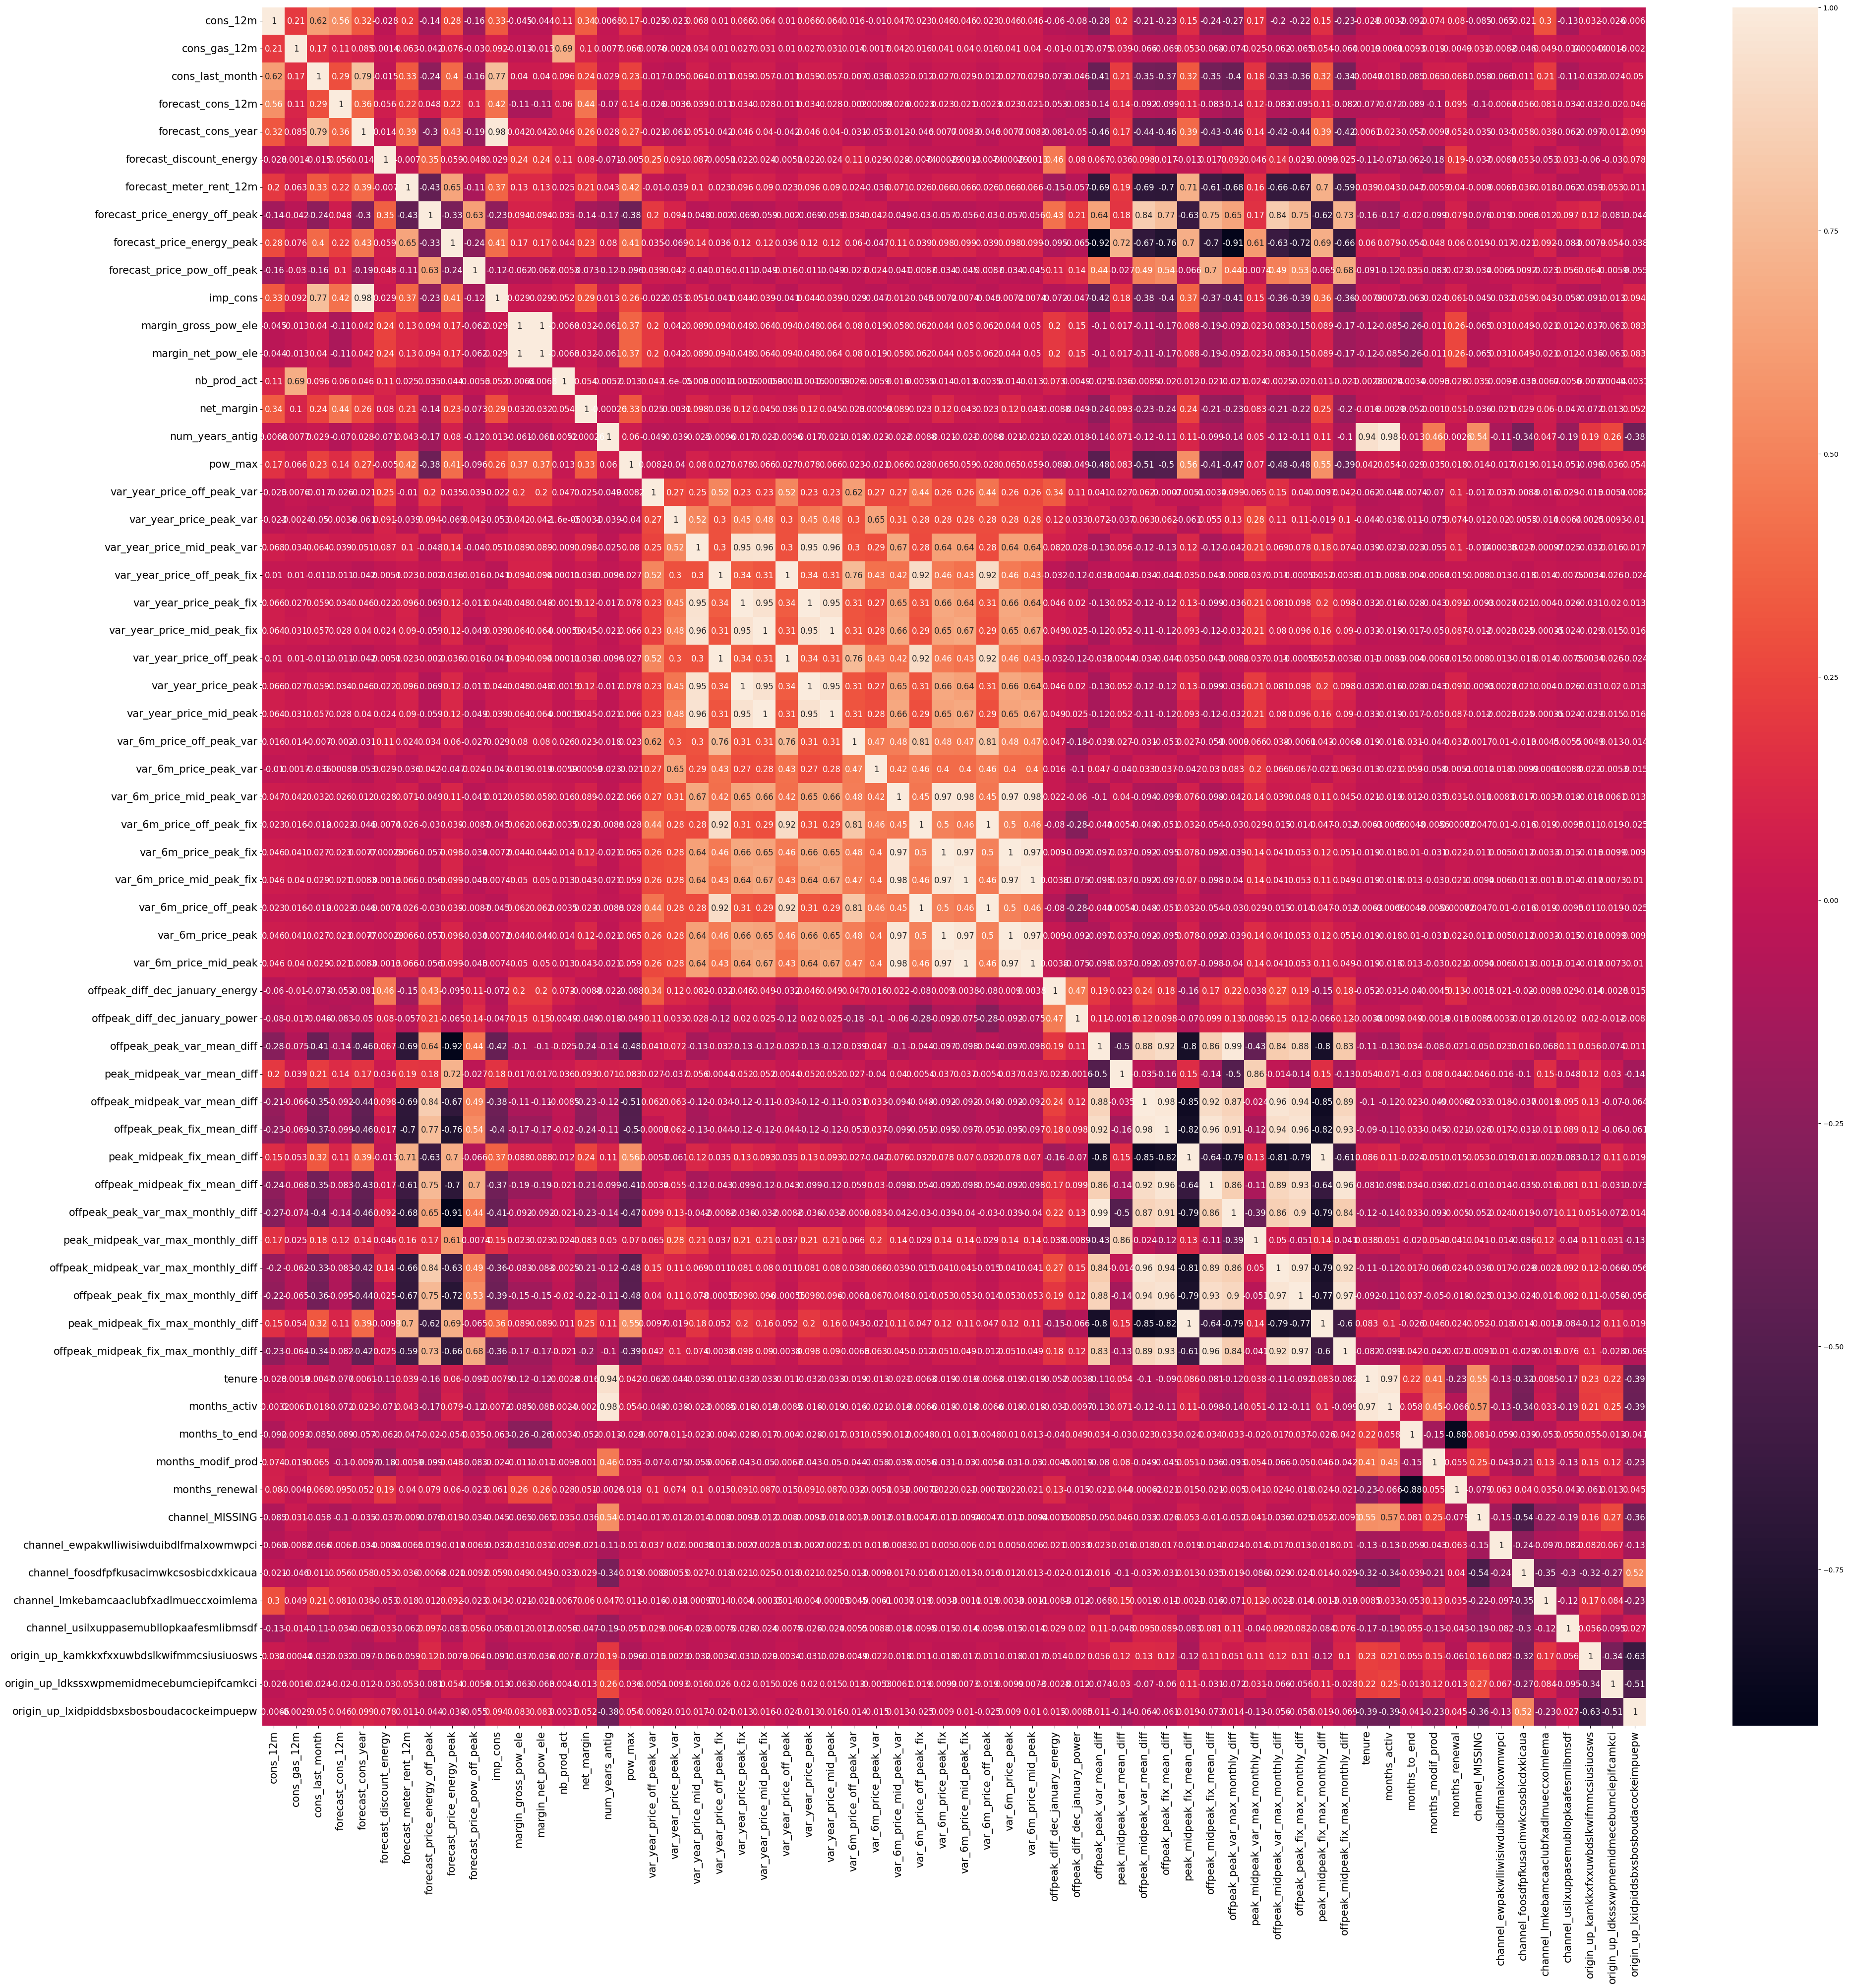

In [87]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
    correlation,
    xticklabels=correlation.columns.values,
    yticklabels=correlation.columns.values,
    annot=True,
    annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [111]:
# set correlation threshold
threshold = 0.9

In [112]:
# create a set to drop highly correlated columns
columns_to_drop = set()

In [113]:
# Find pairs of highly correlated variables
corr_matrix = correlation.abs()

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > threshold:
            colname_i = corr_matrix.columns[i]
            colname_j = corr_matrix.columns[j]
            # Add the column with higher correlation to the set
            if corr_matrix[colname_i].mean() > corr_matrix[colname_j].mean():
                columns_to_drop.add(colname_i)
            else:
                columns_to_drop.add(colname_j)
            high_corr_pairs.append((colname_i, colname_j))

# Display highly correlated pairs
print("Highly Correlated Pairs:")
for pair in high_corr_pairs:
    print(pair)

Highly Correlated Pairs:
('forecast_cons_year', 'imp_cons')
('forecast_price_energy_peak', 'offpeak_peak_var_mean_diff')
('forecast_price_energy_peak', 'offpeak_peak_var_max_monthly_diff')
('margin_gross_pow_ele', 'margin_net_pow_ele')
('num_years_antig', 'tenure')
('num_years_antig', 'months_activ')
('var_year_price_mid_peak_var', 'var_year_price_peak_fix')
('var_year_price_mid_peak_var', 'var_year_price_mid_peak_fix')
('var_year_price_mid_peak_var', 'var_year_price_peak')
('var_year_price_mid_peak_var', 'var_year_price_mid_peak')
('var_year_price_off_peak_fix', 'var_year_price_off_peak')
('var_year_price_off_peak_fix', 'var_6m_price_off_peak_fix')
('var_year_price_off_peak_fix', 'var_6m_price_off_peak')
('var_year_price_peak_fix', 'var_year_price_mid_peak_fix')
('var_year_price_peak_fix', 'var_year_price_peak')
('var_year_price_peak_fix', 'var_year_price_mid_peak')
('var_year_price_mid_peak_fix', 'var_year_price_peak')
('var_year_price_mid_peak_fix', 'var_year_price_mid_peak')
('var_

In [115]:
# Count the occurrences of each column in the pairs
columns_count = Counter([col for pair in high_corr_pairs for col in pair])

# Sort columns by frequency in descending order
sorted_columns = sorted(columns_count, key=columns_count.get, reverse=True)
columns_count

Counter({'forecast_cons_year': 1,
         'imp_cons': 1,
         'forecast_price_energy_peak': 2,
         'offpeak_peak_var_mean_diff': 3,
         'offpeak_peak_var_max_monthly_diff': 3,
         'margin_gross_pow_ele': 1,
         'margin_net_pow_ele': 1,
         'num_years_antig': 2,
         'tenure': 2,
         'months_activ': 2,
         'var_year_price_mid_peak_var': 4,
         'var_year_price_peak_fix': 4,
         'var_year_price_mid_peak_fix': 4,
         'var_year_price_peak': 4,
         'var_year_price_mid_peak': 4,
         'var_year_price_off_peak_fix': 3,
         'var_year_price_off_peak': 3,
         'var_6m_price_off_peak_fix': 3,
         'var_6m_price_off_peak': 3,
         'var_6m_price_mid_peak_var': 4,
         'var_6m_price_peak_fix': 4,
         'var_6m_price_mid_peak_fix': 4,
         'var_6m_price_peak': 4,
         'var_6m_price_mid_peak': 4,
         'offpeak_peak_fix_mean_diff': 7,
         'offpeak_midpeak_var_mean_diff': 4,
         'offpeak_midpe

In [116]:
# Iterate over the sorted columns and drop them if they are part of a high correlation pair
for col in sorted_columns:
    if any(col in pair for pair in high_corr_pairs):
        columns_to_drop.add(col)
        # Remove pairs that contain the dropped column
        high_corr_pairs = [pair for pair in high_corr_pairs if col not in pair]

print("Columns to drop:")
print(columns_to_drop)

Columns to drop:
{'months_activ', 'peak_midpeak_fix_mean_diff', 'var_6m_price_mid_peak_fix', 'peak_midpeak_fix_max_monthly_diff', 'var_6m_price_off_peak_fix', 'forecast_cons_year', 'var_6m_price_peak', 'margin_gross_pow_ele', 'offpeak_midpeak_fix_mean_diff', 'var_6m_price_mid_peak', 'offpeak_midpeak_var_max_monthly_diff', 'var_year_price_peak', 'var_year_price_off_peak_fix', 'offpeak_peak_fix_max_monthly_diff', 'var_year_price_off_peak', 'var_year_price_peak_fix', 'var_year_price_mid_peak_fix', 'var_year_price_mid_peak_var', 'var_6m_price_mid_peak_var', 'var_6m_price_off_peak', 'offpeak_peak_fix_mean_diff', 'num_years_antig', 'offpeak_peak_var_max_monthly_diff', 'offpeak_peak_var_mean_diff', 'tenure', 'var_year_price_mid_peak', 'var_6m_price_peak_fix', 'offpeak_midpeak_var_mean_diff'}


In [117]:
# Drop the columns from the dataframe
df_reduced = df.drop(columns=columns_to_drop)

print("Reduced DataFrame:")
df_reduced.head(3)

Reduced DataFrame:


id  cons_12m  cons_gas_12m  cons_last_month  \
0  24011ae4ebbe3035111d65fa7c15bc57  0.000000      4.739944              0.0   
1  d29c2c54acc38ff3c0614d0a653813dd  3.668479      0.000000              0.0   
2  764c75f661154dac3a6c254cd082ea7d  2.736397      0.000000              0.0   

   forecast_cons_12m  forecast_discount_energy  forecast_meter_rent_12m  \
0           0.000000                       0.0                 0.444045   
1           2.280920                       0.0                 1.237292   
2           1.689841                       0.0                 1.599009   

   forecast_price_energy_off_peak  forecast_price_energy_peak  \
0                        0.114481                    0.098142   
1                        0.145711                    0.000000   
2                        0.165794                    0.087899   

   forecast_price_pow_off_peak  ...  months_modif_prod  months_renewal  \
0                    40.606701  ...                  2               6   
1                    44.311378  ...                 76               4   
2                    44.311378  ...                 68               8   

   channel_MISSING  channel_ewpakwlliwisiwduibdlfmalxowmwpci  \
0                0                                         0   
1                1                                         0   
2                0                                         0   

   channel_foosdfpfkusacimwkcsosbicdxkicaua  \
0                                         1   
1                                         0   
2                                         1   

   channel_lmkebamcaaclubfxadlmueccxoimlema  \
0                                         0   
1                                         0   
2                                         0   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                         0   
1                                         0   
2                                         0   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                           0   
1                                           1   
2                                           1   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                           0   
1                                           0   
2                                           0   

   origin_up_lxidpiddsbxsbosboudacockeimpuepw  
0                                           1  
1                                           0  
2                                           0  

[3 rows x 37 columns]

##### According to correlation matrix, we drop columns that has over 0.9 correlation threshold:
{'months_activ', 'peak_midpeak_fix_mean_diff', 'var_6m_price_mid_peak_fix', 'peak_midpeak_fix_max_monthly_diff', 'var_6m_price_off_peak_fix', 'forecast_cons_year', 'var_6m_price_peak', 'margin_gross_pow_ele', 'offpeak_midpeak_fix_mean_diff', 'var_6m_price_mid_peak', 'offpeak_midpeak_var_max_monthly_diff', 'var_year_price_peak', 'var_year_price_off_peak_fix', 'offpeak_peak_fix_max_monthly_diff', 'var_year_price_off_peak', 'var_year_price_peak_fix', 'var_year_price_mid_peak_fix', 'var_year_price_mid_peak_var', 'var_6m_price_mid_peak_var', 'var_6m_price_off_peak', 'offpeak_peak_fix_mean_diff', 'num_years_antig', 'offpeak_peak_var_max_monthly_diff', 'offpeak_peak_var_mean_diff', 'tenure', 'var_year_price_mid_peak', 'var_6m_price_peak_fix', 'offpeak_midpeak_var_mean_diff'}